In [2]:
import os
import sys
import argparse
import logging
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision.utils import save_image
from PIL import Image, ImageFile
from net import Net
from utils import DEVICE, train_transform, test_transform, FlatFolderDataset, InfiniteSamplerWrapper, plot_grad_flow, adjust_learning_rate

Image.MAX_IMAGE_PIXELS = None  
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = 'cpu'

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# load pretrained checkpoints for the model
os.system("gdown https://drive.google.com/uc?id=1rPB_qnelVVSad6CtadmhRFi0PMI_RKdy")
os.mkdir("checkpoints/")

os.system("unzip -j original_PAMA.zip -d checkpoints/")

Downloading...
From: https://drive.google.com/uc?id=1rPB_qnelVVSad6CtadmhRFi0PMI_RKdy
To: /workspaces/PAMA/original_PAMA.zip
100%|██████████| 158M/158M [00:06<00:00, 22.8MB/s] 


Archive:  original_PAMA.zip
  inflating: checkpoints/.DS_Store   
  inflating: checkpoints/PAMA1.pth   
  inflating: checkpoints/PAMA3.pth   
  inflating: checkpoints/PAMA2.pth   
  inflating: checkpoints/decoder.pth  
  inflating: checkpoints/encoder.pth  


0

In [3]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

# https://www.geeksforgeeks.org/histogram-matching-with-opencv-scikit-image-and-python/
def display_histograms(image, reference, matched):

    # displaying histograms.
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

    for i, img in enumerate((image, reference, matched)):
        for c, c_color in enumerate(('red', 'green', 'blue')):
            img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
            axes[c, i].plot(bins, img_hist / img_hist.max())
            img_cdf, bins = exposure.cumulative_distribution(img[..., c])
            axes[c, i].plot(bins, img_cdf)
            axes[c, 0].set_ylabel(c_color)

    axes[0, 0].set_title('Source image')
    axes[0, 1].set_title('Reference image')
    axes[0, 2].set_title('Matched image')
    plt.tight_layout()
    plt.show()

def match_image_histograms(img_source: Image, img_target: Image) -> Image:
  np_source = np.array(img_source)
  np_target = np.array(img_target)
  np_out = match_histograms(np_source, np_target, channel_axis=2)
  display_histograms(np_source, np_target, np_out)
  return Image.fromarray(np_out, mode=img_source.mode)

## A. Recolor Style Image with Histogram Matching

In [6]:
def eval(args):
    mes = "current pid: " + str(os.getpid())
    print(mes)
    logging.info(mes)
    model = Net(args)
    model.eval()
    model = model.to(DEVICE)

    tf = test_transform()
    img_c = Image.open(args.content).convert('RGB')
    img_s = Image.open(args.style).convert('RGB')

    if args.preserve_color:
        img_s = match_image_histograms(img_s, img_c)
        Is = tf(img_s).to(DEVICE)
        save_image(Is, 'recolor.png')
    else:
        Is = tf(img_s).to(DEVICE)

    Ic = tf(img_c).to(DEVICE)

    Ic = Ic.unsqueeze(dim=0)
    Is = Is.unsqueeze(dim=0)

    with torch.no_grad():
        Ics = model(Ic, Is)

    name_cs = args.out_dir + args.out_prefix + 'recolor-histogram-match.png'
    save_image(Ics[0], name_cs)

current pid: 13349


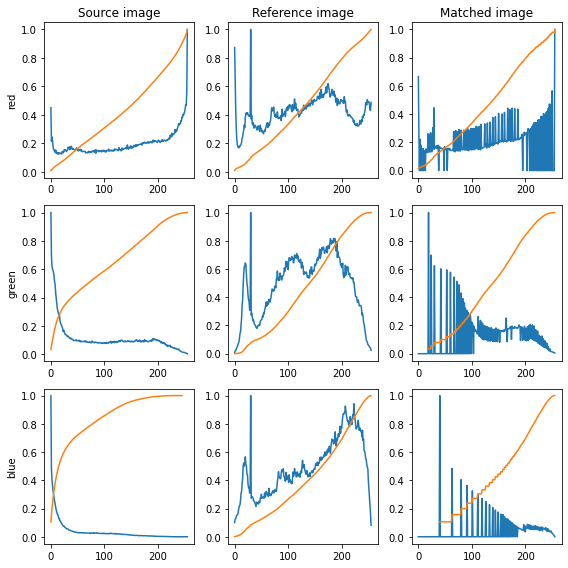

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [8]:
workspace = './'
samples_dir = workspace + 'samples/'
content_dir = workspace + 'content/'
style_dir = workspace + 'style/'
out_dir = workspace + 'out/1-recolor-style-histogram-matching/'

args = type('obj', (object,), {})

args.pretrained = True
args.requires_grad = True

args.training = False
args.run_folder = False
args.content = samples_dir + '1c.png'
args.style = samples_dir + '1s.png'
args.alpha = 1.0
args.preserve_color = True
args.out_dir = out_dir
args.out_prefix = 'transfer-'

eval(args)

## B. Full Style with HSV Replacement

In [14]:
# 3 methods of HSV Style Transfer to try:
#    1. Convert normal output to HSV, replace Hue with that of input content
#      a. save output, read as HSV, replace hue, save again
#    2. Stylize greyscale image, replace HS channels
#    3. Can I stylize the Hue map without changing the Hues?

def eval(args):
    mes = "current pid: " + str(os.getpid())
    print(mes)
    logging.info(mes)

    model = Net(args)
    model.eval()
    model = model.to(DEVICE)
    
    tf = test_transform()

    img_c = Image.open(args.content).convert('RGB')
    img_s = Image.open(args.style).convert('RGB')

    Ic = tf(img_c).to(DEVICE)
    Is = tf(img_s).to(DEVICE)

    Ic = Ic.unsqueeze(dim=0)
    Is = Is.unsqueeze(dim=0)

    with torch.no_grad():
        Ics = model(Ic, Is)

    fn_full = args.out_dir + args.out_prefix + 'full.png'
    fn_sat_val = args.out_dir + args.out_prefix + 'sat+val.png'
    fn_val = args.out_dir + args.out_prefix + 'val.png'
    fn_sat = args.out_dir + args.out_prefix + 'sat.png'
    fn_hue = args.out_dir + args.out_prefix + 'hue.png'
    fn_hue_val = args.out_dir + args.out_prefix + 'hue+val.png'
    fn_hue_sat = args.out_dir + args.out_prefix + 'hue+sat.png'

    save_image(Ics[0], fn_full)
    img_full = Image.open(fn_full).convert('RGB').convert('HSV')

    arr_sat_val = np.array(img_full).copy()
    H, W, _ = arr_sat_val.shape

    arr_c_hsv = np.array(img_c.resize((W,H)).convert('HSV'))
    arr_c_hsv
    c_H = arr_c_hsv[:,:,0]
    c_S = arr_c_hsv[:,:,1]
    c_V = arr_c_hsv[:,:,2]

    arr_sat_val[:,:,0] = c_H[:H, :W]
    img_sat_val = Image.fromarray(arr_sat_val, mode='HSV')
    img_sat_val.convert('RGB').save(fn_sat_val)

    arr_val = arr_sat_val
    arr_val[:,:,1] = c_S[:H,:W]
    img_val = Image.fromarray(arr_val, mode='HSV')
    img_val.convert('RGB').save(fn_val)

    arr_hue_val = np.array(img_full).copy()
    arr_hue_val[:,:,1] = c_S[:H,:W]
    img_hue_val = Image.fromarray(arr_hue_val, mode='HSV')
    img_hue_val.convert('RGB').save(fn_hue_val)

    arr_hue = arr_hue_val
    arr_hue[:,:,2] = c_V[:H,:W]
    img_hue = Image.fromarray(arr_hue, mode='HSV')
    img_hue.convert('RGB').save(fn_hue)

    arr_hue_sat = np.array(img_full).copy()
    arr_hue_sat[:,:,2] = arr_hue[:,:,2]
    img_hue_sat = Image.fromarray(arr_hue_sat, mode='HSV')
    img_hue_sat.convert('RGB').save(fn_hue_sat)

    arr_sat = arr_hue_sat
    arr_sat[:,:,0] = arr_val[:,:,0]
    img_sat = Image.fromarray(arr_sat, mode='HSV')
    img_sat.convert('RGB').save(fn_sat)


In [15]:
workspace = './'
samples_dir = workspace + 'samples/'
content_dir = workspace + 'content/'
style_dir = workspace + 'style/'
out_dir = workspace + 'out/1-full-style-HSV-replace/'

args = type('obj', (object,), {})

args.pretrained = True
args.requires_grad = True

args.training = False
args.run_folder = False
args.content = samples_dir + '1c.png'
args.style = samples_dir + '1s.png'
args.alpha = 1.0
args.out_dir = out_dir
args.out_prefix = 'transfer-'

eval(args)

current pid: 13349


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


FileNotFoundError: [Errno 2] No such file or directory: './out/1-full-style-HSV-replace/transfer-full-0.png'

## C. Grayscale-only Style with HSV Replacement

The method above performs a version of value-only transfer by performing a full style transfer, and replacing the hue and saturation channels with the originals

In [41]:
# 3 methods of HSV Style Transfer to try:
#    1. Convert normal output to HSV, replace Hue with that of input content
#      a. save output, read as HSV, replace hue, save again
#    2. Stylize greyscale image, replace HS channels
#    3. Can I stylize the Hue map without changing the Hues?

def eval(args):
    mes = "current pid: " + str(os.getpid())
    print(mes)
    logging.info(mes)

    model = Net(args)
    model.eval()
    model = model.to(DEVICE)
    
    tf = test_transform()

    img_c = Image.open(args.content).convert('RGB')
    img_s = Image.open(args.style).convert('RGB')

    img_c_gs = img_c.convert('L').convert('RGB')
    img_s_gs = img_s.convert('L').convert('RGB')

    img_s_hist = match_image_histograms(img_s, img_c)
    img_s_gs_hist = match_image_histograms(img_s_gs, img_c_gs)

    pt_img_c = tf(img_c).to(DEVICE)
    pt_img_c_gs = tf(img_c_gs).to(DEVICE)

    pt_img_s = tf(img_s).to(DEVICE)
    pt_img_s_hist = tf(img_s_hist).to(DEVICE)
    pt_img_s_gs = tf(img_s_gs).to(DEVICE)
    pt_img_s_gs_hist = tf(img_s_gs_hist).to(DEVICE)

    Ic = torch.stack((pt_img_c, pt_img_c, pt_img_c_gs, pt_img_c, pt_img_c_gs, pt_img_c_gs, pt_img_c, pt_img_c_gs))
    Is = torch.stack((pt_img_s, pt_img_s_hist, pt_img_s_hist, pt_img_s_gs, pt_img_s, pt_img_s_gs, pt_img_s_gs_hist, pt_img_s_gs_hist))

    with torch.no_grad():
        Ics = model(Ic, Is)

    for i in range(Ics.shape[0]):
        fn_full = args.out_dir + args.out_prefix + 'full-' + str(i) + '.png'
        fn_val = args.out_dir + args.out_prefix + 'val-' + str(i) + '.png'

        save_image(Ics[i], fn_full)
        img_full = Image.open(fn_full).convert('RGB').convert('HSV')

        arr_sat_val = np.array(img_full).copy()
        H, W, _ = arr_sat_val.shape

        arr_c_hsv = np.array(img_c.resize((W,H)).convert('HSV'))
        c_H = arr_c_hsv[:,:,0]
        c_S = arr_c_hsv[:,:,1]
        c_V = arr_c_hsv[:,:,2]
        arr_sat_val[:,:,0] = c_H[:H, :W]
        arr_val = arr_sat_val
        arr_val[:,:,1] = c_S[:H,:W]
        img_val = Image.fromarray(arr_val, mode='HSV')
        img_val.convert('RGB').save(fn_val)

current pid: 13349


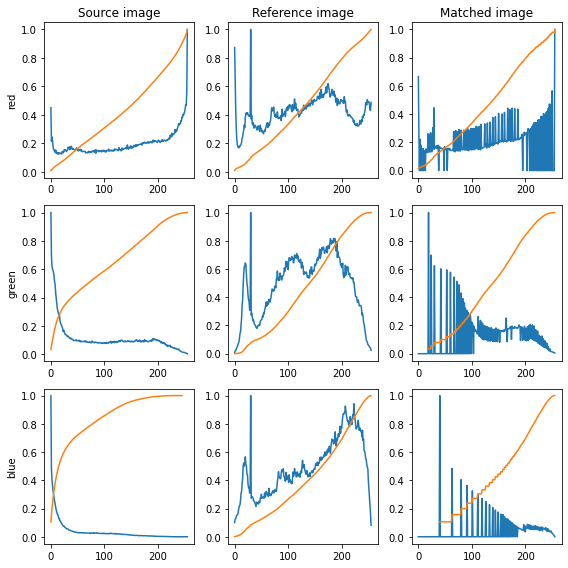

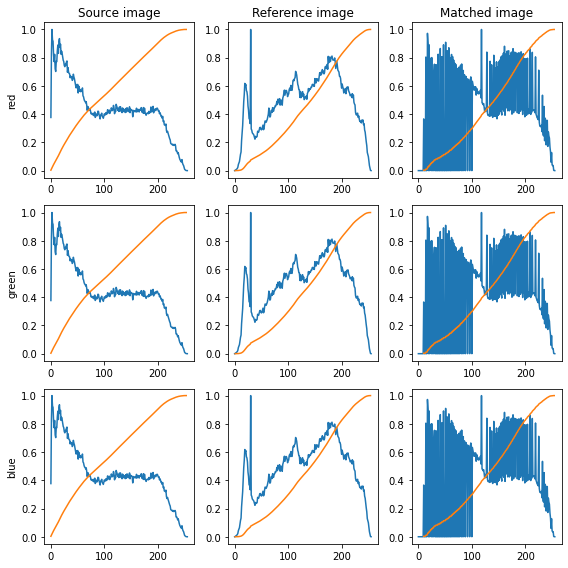

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [42]:
workspace = './'
samples_dir = workspace + 'samples/'
content_dir = workspace + 'content/'
style_dir = workspace + 'style/'
out_dir = workspace + 'out/1C/'

args = type('obj', (object,), {})

args.pretrained = True
args.requires_grad = True

args.training = False
args.run_folder = False
args.content = samples_dir + '1c.png'
args.style = samples_dir + '1s.png'
args.alpha = 1.0
args.out_dir = out_dir
args.out_prefix = 'transfer-'

eval(args)